<a href="https://colab.research.google.com/github/zubejda/Advanced_DL/blob/main/Assignment4_SelfSupervision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alternatvie text](https://www.doc.zuv.fau.de//M/FAU-Logo/01_FAU_Kernmarke/Web/FAU_Kernmarke_Q_RGB_blue.svg)


# Assignment 4: Self-Supervised Learning

In the lecture you have learned the main concept of Self-Supervised Learning, that is to derive supervision from proxy / surrogate tasks defined over the data. Over the past years, several proxy tasks have been developed to improve the performance of deep neural networks on downstream tasks. There are two main steps inolved in the self-supervision procedure. First, pre-training the backbone model on the pretext task. Next, the backbone model is finetuned on the downstream task.

In this assignment, you'll work on the task of microscopy image cell segmentation. You're required to implement a proxy task called "Pseudo-label microscopy image cell segmentation". This proxy task pre-trains a cell segmentation network using pseudo-cell segmentation maps extracted via classical computer vision operations. The below figure illustrates the training procedure.

<center><img src="pretrain.png"/></center>

<center><img src="finetune.png"/></center>

You'll need to install the following libraries:
- PyTorch
- Torchvision
- OpenCV
- Matplotlib

## 1. Data Preparation

First, you're required to download the microscopy image dataset, which you'll work with throughout this assignment. You can use this [link](https://github.com/unidesigner/groundtruth-drosophila-vnc) for download. The task involved in the dataset is binary cell segmentation, where the cells of interest are mitochondria. The microscopy images could be found in the directory "stack1/raw/" , while "stack1/mitochondria/" contains the corresponding binary cell segmentation groundtruth.

The dataset contains in total 20 images of resolution 1024x1024. It would be difficult to train on full resolution images, due to the high resolution. Alternatively, this issue could be solve by training with image crops. Note, the groundtruth should also be cropped at the same crop window location. The below class implements RandomCrop. Use a crop size of 256x256.

In [86]:
import torch
import random
import torchvision.transforms.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from PIL import Image, ImageDraw
import os
import cv2
import numpy as np
import subprocess
import matplotlib.pyplot as plt
from tqdm import tqdm
from google.colab.patches import cv2_imshow
from scipy import signal

In [22]:
class RandomCrop(object):

    def __init__(self, size, padding=None, pad_if_needed=False, fill=0, padding_mode='constant'):

        self.size = size
        self.padding = padding
        self.pad_if_needed = pad_if_needed
        self.fill = fill
        self.padding_mode = padding_mode

    @staticmethod
    def get_params(img, output_size):

        w, h = img.size
        th, tw = output_size
        if w == tw and h == th:
            return 0, 0, h, w

        i = random.randint(0, h - th)
        j = random.randint(0, w - tw)
        return i, j, th, tw

    def __call__(self, data):

        img, mask = data["image"], data["label"]
        # pad the width if needed
        if self.pad_if_needed and img.shape[0] < self.size[1]:
            img = F.pad(img, (self.size[1] - img.shape[0], 0), self.fill, self.padding_mode)
            mask = F.pad(mask, (self.size[1] - mask.shape[0], 0), self.fill, self.padding_mode)
        # pad the height if needed
        if self.pad_if_needed and img.shape[1] < self.size[0]:
            img = F.pad(img, (0, self.size[0] - img.shape[1]), self.fill, self.padding_mode)
            mask = F.pad(mask, (0, self.size[0] - mask.shape[1]), self.fill, self.padding_mode)
        done = False
        while not done:
            i, j, h, w = self.get_params(img, self.size)
            crop_image = F.crop(img, i, j, h, w)
            crop_mask = F.crop(mask, i, j, h, w)
            crop_image = np.array(crop_image)
            crop_mask = np.array(crop_mask)
            if np.sum(crop_mask==1, axis=0).sum() > int(0.1*h*w):
            # if (crop_mask==1).sum(dim=0).sum().item() > int(0.1*h*w):
                # print(i,j,h,w)
                return crop_image,crop_mask

Next, you will have to implement your own custom dataset to access the images during training and testing. The dataset will be split into 14 images for training and the rest for testing. You can pick the first 14 images for training, while use the rest for testing.

In [101]:
class DrosophilaDataset(Dataset):
    def __init__(self, repo_url='https://github.com/unidesigner/groundtruth-drosophila-vnc', local_dir='groundtruth-drosophila-vnc', transform=None, crop_size=(256, 256), training=1):
        self.repo_url = repo_url
        self.local_dir = local_dir
        self.transform = transform
        self.clone_repo()
        self.crop_transform = RandomCrop(size=crop_size)
        self.training = training  # if we ant to load the training data 1, test data 2
        self.images = self.get_image_files()
        self.annotations = self.load_annotations()

    def clone_repo(self):
        if not os.path.exists(self.local_dir):
            subprocess.run(['git', 'clone', self.repo_url])

    def get_image_files(self):
        img_files = []
        img_path = self.local_dir + '/stack' + str(self.training) + '/raw'
        for file in os.listdir(img_path):
            if file.endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff')):
                img_files.append(os.path.join(img_path, file))

        random.shuffle(img_files)
        return img_files

    def load_annotations(self):
        annotations = {}
        annotations_path = self.local_dir + '/stack1/mitochondria'
        for file in os.listdir(annotations_path):
            key = file.split('.')[0]
            segmentation = Image.open(os.path.join(annotations_path, file))
            segmentation = np.array(segmentation)
            segmentation[segmentation>0] = 1  # ensures that the segmentation is binary
            annotations[key] = np.array(segmentation, dtype='bool')
        return annotations

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        # print(img_path)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(np.float32)
        im_type = image.dtype

        img_key = os.path.splitext(os.path.basename(img_path))[0]
        annotation = self.annotations.get(img_key, None)
        an_type = annotation.dtype

        if self.transform:
            image = Image.fromarray(image)
            annotation = Image.fromarray(annotation)
            data = {"image": image, "label": annotation}
            image, annotation = self.crop_transform(data)
            image, annotation = np.array(image, dtype=im_type), np.array(annotation, dtype=an_type)

        image = np.expand_dims(image, axis=0)

        return image, annotation

    def visualize(self, img, ann, color=0, alpha=0.5):
        # if color = 0 segmentation is red, 1 is green, 2 is blue

        image = img.squeeze()

        seg_color = [0, 0, 0]
        seg_color[color] = 255
        segmentation_overlay = np.zeros(image.shape + (3,))
        segmentation_overlay[ann == 1] = seg_color

        image = np.stack((image,)*3, axis=-1)
        combined = (image * (1 - alpha) + segmentation_overlay * alpha).astype(np.uint8)
        plt.imshow(combined)
        plt.show()

## 2. Visualize Data

Visualize some of the microscopy data i.e. image and groundtruth without cropping.

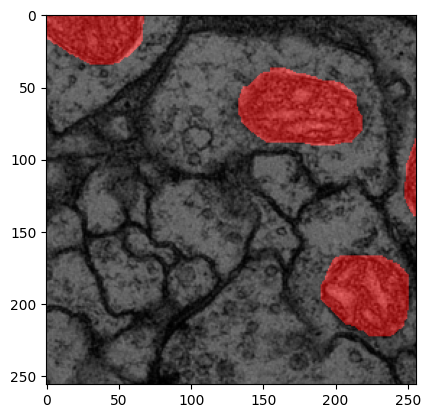

In [102]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = DrosophilaDataset(transform=True)
example_img, example_mask = dataset[0]
dataset.visualize(example_img, example_mask)

## 3. Supervised Learning (Learning from scratch)

In this part, you will train a fully convolutional regression network (FCRN) with randomly initialized weights and full supervision. Moreover, you should test the trained model on the test set. Use an Adam optimizer with 0.001 learning rate, train for 100 epochs and set the batch size to 14. Furthemore, you should use nn.BCEwithLogitsLoss(). Note since the number of pixels annotated as a foreground is much less than the background you should use weighted BCEloss i.e. nn.BCEwithLogitsLoss(weight=calc_weights(labels)).



In [103]:
def conv_bn_relu(in_channels, out_channels, kernel_size,affine=False):
    layer = []
    layer.append(nn.Conv2d(in_channels, out_channels, kernel_size, padding=1, bias=False))
    layer.append(nn.BatchNorm2d(out_channels,affine=affine))
    layer.append(nn.ReLU(inplace=True))
    return nn.Sequential(*layer)


def conv_bn_relu_transpose(in_channels, out_channels, kernel_size,affine=False):
    layer = []
    layer.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=2, bias=False))
    layer.append(nn.BatchNorm2d(out_channels,affine=affine))
    layer.append(nn.ReLU(inplace=True))
    return nn.Sequential(*layer)

class FCRN(nn.Module):
    def __init__(self,in_channels=1, out_channels=32, kernel_size=3,affine=True):

        super(FCRN, self).__init__()
        # Encoder
        self.conv1 = conv_bn_relu(in_channels, out_channels, kernel_size,affine=affine)
        self.conv2 = conv_bn_relu(out_channels, out_channels * 2, kernel_size,affine=affine)
        self.conv3 = conv_bn_relu(out_channels * 2, out_channels * 4, kernel_size,affine=affine)

        self.maxpool = nn.MaxPool2d(2, 2)

        # LatentSpace
        self.conv4 = conv_bn_relu(out_channels * 4, out_channels * 16, kernel_size,affine=affine)

        # Decoder
        self.conv5 = conv_bn_relu_transpose(out_channels * 16, out_channels * 4, 2,affine=affine)
        self.conv6 = conv_bn_relu_transpose(out_channels * 4, out_channels * 2, 2,affine=affine)
        self.conv7 = conv_bn_relu_transpose(out_channels * 2, out_channels, 2,affine=affine)
        self.conv8 = nn.Conv2d(out_channels, in_channels, 3, padding=1)


        self._initialize_weights()
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.maxpool(self.conv2(x))
        x = self.maxpool(self.conv3(x))

        x = self.conv4(x)

        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        out = self.conv8(x)
        return out

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.normal_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            if isinstance(m,nn.ConvTranspose2d):
                init.normal_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

            elif isinstance(m, nn.BatchNorm2d):
                if m.affine:
                    init.constant_(m.weight, 0.1)
                    init.constant_(m.bias, 0)

In [104]:
example_input = torch.randn(1, 1, 256, 256).to(device)
example_model = FCRN(in_channels=1, out_channels=32, kernel_size=3, affine=True).to(device)
ex_output = example_model(example_input)
print(ex_output.shape)

torch.Size([1, 1, 256, 256])


In [105]:
def calc_weights(labels):
    pos_tensor = torch.ones_like(labels)

    for label_idx in range(0, labels.size(0)):
        pos_weight = torch.sum(labels[label_idx] == 1)
        neg_weight = torch.sum(labels[label_idx] == 0)
        ratio = float(neg_weight.item() / pos_weight.item())
        pos_tensor[label_idx] = ratio * pos_tensor[label_idx]

    return pos_tensor

To assess the segmentation performance, we will use the below function which calculate the mean intersection over union. For more information about the metric you can refer to this [blog](https://hasty.ai/docs/mp-wiki/metrics/iou-intersection-over-union#:~:text=To%20define%20the%20term%2C%20in,matches%20the%20ground%20truth%20data.).

In [106]:
def intersection_over_union(tensor, labels, device=torch.device("cpu")):
    iou = 0
    foreground_acc = 0

    labels_tens = labels.type(torch.BoolTensor)
    ones_tens = torch.ones_like(tensor, device=device)
    zeros_tens = torch.zeros_like(tensor, device=device)
    if tensor.shape[0] > 1:
        temp_tens = torch.where(tensor >= 0.5, ones_tens, zeros_tens)
        intersection_tens = (temp_tens.squeeze().type(torch.BoolTensor) & labels_tens.squeeze()).float().sum((1, 2))

        union_tens = (temp_tens.squeeze().type(torch.BoolTensor) | labels_tens.squeeze()).float().sum((1, 2))
        iou += torch.mean((intersection_tens + 0.0001) / (union_tens + 0.0001))
        foreground_acc += intersection_tens
    else:
        temp_tens = torch.where(tensor >= 0.5, ones_tens, zeros_tens)
        intersection_tens = (temp_tens.squeeze().type(torch.BoolTensor) & labels_tens.squeeze()).float().sum()
        union_tens = (temp_tens.squeeze().type(torch.BoolTensor) | labels_tens.squeeze()).float().sum()
        iou += torch.sum((intersection_tens + 0.0001) / (union_tens + 0.0001))
        foreground_acc += intersection_tens

    total_iou = iou
    return total_iou

In [127]:
model = FCRN(in_channels=1, out_channels=32, kernel_size=3, affine=True).to(device)

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define loss function (placeholder, will be set within the loop)
criterion = nn.BCEWithLogitsLoss()

# Create dataset and dataloaders
dataset = DrosophilaDataset(transform=True, training=1)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=14, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=14, shuffle=False)

num_epochs = 100
train_loss_history = []
val_loss_history = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for i, (inputs, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}")):
        inputs, labels = inputs.to(device), labels.to(device)
        # print(inputs.shape, inputs[0].dtype)

        # Calculate weights for BCEWithLogitsLoss
        weights = calc_weights(labels).to(device)
        criterion = nn.BCEWithLogitsLoss(weight=weights)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs).squeeze()
        # outputs[outputs < 0] = 0
        # outputs[outputs > 0] = 1
        # print(outputs.shape, labels.shape)
        loss = criterion(outputs, labels.float())

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        train_loss_history.append(running_loss/100)
        # if i % 100 == 99:  # Print every 100 mini-batches
        print(f"[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 100:.3f}")
        running_loss = 0.0

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Calculate weights for BCEWithLogitsLoss
            weights = calc_weights(labels).to(device)
            criterion = nn.BCEWithLogitsLoss(weight=weights)

            outputs = model(inputs).squeeze()
            # outputs[outputs < 0] = 0
            # outputs[outputs > 0] = 1
            loss = criterion(outputs, labels.float())

            outputs = outputs.cpu()
            iou = intersection_over_union(outputs, labels)
            val_loss += loss.item()
            val_loss_history.append(val_loss / len(val_loader))

    print(f"Epoch {epoch + 1} validation loss: {val_loss / len(val_loader):.3f}", f"IoU: {iou.item():.3f}")

print("Finished Training")

Epoch 1/100: 100%|██████████| 2/2 [00:00<00:00,  6.71it/s]


[Epoch 1, Batch 1] loss: 0.007
[Epoch 1, Batch 2] loss: 0.007
Epoch 1 validation loss: 4.081 IoU: 0.126


Epoch 2/100: 100%|██████████| 2/2 [00:00<00:00,  7.07it/s]


[Epoch 2, Batch 1] loss: 0.006
[Epoch 2, Batch 2] loss: 0.006
Epoch 2 validation loss: 1.570 IoU: 0.121


Epoch 3/100: 100%|██████████| 2/2 [00:00<00:00,  9.16it/s]


[Epoch 3, Batch 1] loss: 0.006
[Epoch 3, Batch 2] loss: 0.006
Epoch 3 validation loss: 0.846 IoU: 0.087


Epoch 4/100: 100%|██████████| 2/2 [00:00<00:00,  9.86it/s]


[Epoch 4, Batch 1] loss: 0.005
[Epoch 4, Batch 2] loss: 0.005
Epoch 4 validation loss: 0.637 IoU: 0.059


Epoch 5/100: 100%|██████████| 2/2 [00:00<00:00, 10.05it/s]


[Epoch 5, Batch 1] loss: 0.005
[Epoch 5, Batch 2] loss: 0.005
Epoch 5 validation loss: 0.543 IoU: 0.028


Epoch 6/100: 100%|██████████| 2/2 [00:00<00:00,  9.24it/s]


[Epoch 6, Batch 1] loss: 0.005
[Epoch 6, Batch 2] loss: 0.004
Epoch 6 validation loss: 0.439 IoU: 0.013


Epoch 7/100: 100%|██████████| 2/2 [00:00<00:00, 10.64it/s]


[Epoch 7, Batch 1] loss: 0.004
[Epoch 7, Batch 2] loss: 0.004
Epoch 7 validation loss: 0.406 IoU: 0.007


Epoch 8/100: 100%|██████████| 2/2 [00:00<00:00, 10.40it/s]


[Epoch 8, Batch 1] loss: 0.004
[Epoch 8, Batch 2] loss: 0.004
Epoch 8 validation loss: 0.358 IoU: 0.004


Epoch 9/100: 100%|██████████| 2/2 [00:00<00:00,  9.68it/s]


[Epoch 9, Batch 1] loss: 0.004
[Epoch 9, Batch 2] loss: 0.004
Epoch 9 validation loss: 0.387 IoU: 0.008


Epoch 10/100: 100%|██████████| 2/2 [00:00<00:00, 10.07it/s]


[Epoch 10, Batch 1] loss: 0.004
[Epoch 10, Batch 2] loss: 0.003
Epoch 10 validation loss: 0.383 IoU: 0.005


Epoch 11/100: 100%|██████████| 2/2 [00:00<00:00, 11.20it/s]


[Epoch 11, Batch 1] loss: 0.004
[Epoch 11, Batch 2] loss: 0.003
Epoch 11 validation loss: 0.320 IoU: 0.005


Epoch 12/100: 100%|██████████| 2/2 [00:00<00:00, 10.63it/s]


[Epoch 12, Batch 1] loss: 0.003
[Epoch 12, Batch 2] loss: 0.003
Epoch 12 validation loss: 0.361 IoU: 0.006


Epoch 13/100: 100%|██████████| 2/2 [00:00<00:00, 10.37it/s]


[Epoch 13, Batch 1] loss: 0.003
[Epoch 13, Batch 2] loss: 0.003
Epoch 13 validation loss: 0.333 IoU: 0.005


Epoch 14/100: 100%|██████████| 2/2 [00:00<00:00, 10.77it/s]


[Epoch 14, Batch 1] loss: 0.003
[Epoch 14, Batch 2] loss: 0.003
Epoch 14 validation loss: 0.311 IoU: 0.004


Epoch 15/100: 100%|██████████| 2/2 [00:00<00:00,  9.79it/s]


[Epoch 15, Batch 1] loss: 0.003
[Epoch 15, Batch 2] loss: 0.003
Epoch 15 validation loss: 0.329 IoU: 0.005


Epoch 16/100: 100%|██████████| 2/2 [00:00<00:00, 10.60it/s]


[Epoch 16, Batch 1] loss: 0.003
[Epoch 16, Batch 2] loss: 0.003
Epoch 16 validation loss: 0.353 IoU: 0.002


Epoch 17/100: 100%|██████████| 2/2 [00:00<00:00,  9.88it/s]


[Epoch 17, Batch 1] loss: 0.003
[Epoch 17, Batch 2] loss: 0.003
Epoch 17 validation loss: 0.330 IoU: 0.003


Epoch 18/100: 100%|██████████| 2/2 [00:00<00:00, 10.82it/s]


[Epoch 18, Batch 1] loss: 0.003
[Epoch 18, Batch 2] loss: 0.003
Epoch 18 validation loss: 0.339 IoU: 0.003


Epoch 19/100: 100%|██████████| 2/2 [00:00<00:00,  9.75it/s]


[Epoch 19, Batch 1] loss: 0.003
[Epoch 19, Batch 2] loss: 0.003
Epoch 19 validation loss: 0.246 IoU: 0.004


Epoch 20/100: 100%|██████████| 2/2 [00:00<00:00, 10.05it/s]


[Epoch 20, Batch 1] loss: 0.003
[Epoch 20, Batch 2] loss: 0.003
Epoch 20 validation loss: 0.265 IoU: 0.006


Epoch 21/100: 100%|██████████| 2/2 [00:00<00:00, 10.33it/s]


[Epoch 21, Batch 1] loss: 0.003
[Epoch 21, Batch 2] loss: 0.003
Epoch 21 validation loss: 0.323 IoU: 0.006


Epoch 22/100: 100%|██████████| 2/2 [00:00<00:00,  9.69it/s]


[Epoch 22, Batch 1] loss: 0.003
[Epoch 22, Batch 2] loss: 0.003
Epoch 22 validation loss: 0.285 IoU: 0.013


Epoch 23/100: 100%|██████████| 2/2 [00:00<00:00, 10.43it/s]


[Epoch 23, Batch 1] loss: 0.003
[Epoch 23, Batch 2] loss: 0.002
Epoch 23 validation loss: 0.310 IoU: 0.015


Epoch 24/100: 100%|██████████| 2/2 [00:00<00:00, 10.87it/s]


[Epoch 24, Batch 1] loss: 0.003
[Epoch 24, Batch 2] loss: 0.003
Epoch 24 validation loss: 0.272 IoU: 0.020


Epoch 25/100: 100%|██████████| 2/2 [00:00<00:00, 10.79it/s]


[Epoch 25, Batch 1] loss: 0.003
[Epoch 25, Batch 2] loss: 0.003
Epoch 25 validation loss: 0.252 IoU: 0.010


Epoch 26/100: 100%|██████████| 2/2 [00:00<00:00,  9.62it/s]


[Epoch 26, Batch 1] loss: 0.002
[Epoch 26, Batch 2] loss: 0.002
Epoch 26 validation loss: 0.362 IoU: 0.017


Epoch 27/100: 100%|██████████| 2/2 [00:00<00:00,  9.57it/s]


[Epoch 27, Batch 1] loss: 0.003
[Epoch 27, Batch 2] loss: 0.002
Epoch 27 validation loss: 0.295 IoU: 0.017


Epoch 28/100: 100%|██████████| 2/2 [00:00<00:00, 10.63it/s]


[Epoch 28, Batch 1] loss: 0.002
[Epoch 28, Batch 2] loss: 0.002
Epoch 28 validation loss: 0.266 IoU: 0.016


Epoch 29/100: 100%|██████████| 2/2 [00:00<00:00, 10.03it/s]


[Epoch 29, Batch 1] loss: 0.002
[Epoch 29, Batch 2] loss: 0.002
Epoch 29 validation loss: 0.267 IoU: 0.051


Epoch 30/100: 100%|██████████| 2/2 [00:00<00:00,  9.76it/s]


[Epoch 30, Batch 1] loss: 0.002
[Epoch 30, Batch 2] loss: 0.003
Epoch 30 validation loss: 0.205 IoU: 0.118


Epoch 31/100: 100%|██████████| 2/2 [00:00<00:00,  9.40it/s]


[Epoch 31, Batch 1] loss: 0.003
[Epoch 31, Batch 2] loss: 0.003
Epoch 31 validation loss: 0.221 IoU: 0.231


Epoch 32/100: 100%|██████████| 2/2 [00:00<00:00, 10.87it/s]


[Epoch 32, Batch 1] loss: 0.002
[Epoch 32, Batch 2] loss: 0.002
Epoch 32 validation loss: 0.237 IoU: 0.270


Epoch 33/100: 100%|██████████| 2/2 [00:00<00:00, 10.10it/s]


[Epoch 33, Batch 1] loss: 0.002
[Epoch 33, Batch 2] loss: 0.002
Epoch 33 validation loss: 0.208 IoU: 0.325


Epoch 34/100: 100%|██████████| 2/2 [00:00<00:00,  7.69it/s]


[Epoch 34, Batch 1] loss: 0.002
[Epoch 34, Batch 2] loss: 0.002
Epoch 34 validation loss: 0.249 IoU: 0.294


Epoch 35/100: 100%|██████████| 2/2 [00:00<00:00,  8.80it/s]


[Epoch 35, Batch 1] loss: 0.002
[Epoch 35, Batch 2] loss: 0.002
Epoch 35 validation loss: 0.239 IoU: 0.253


Epoch 36/100: 100%|██████████| 2/2 [00:00<00:00,  8.18it/s]


[Epoch 36, Batch 1] loss: 0.002
[Epoch 36, Batch 2] loss: 0.002
Epoch 36 validation loss: 0.214 IoU: 0.323


Epoch 37/100: 100%|██████████| 2/2 [00:00<00:00,  7.64it/s]


[Epoch 37, Batch 1] loss: 0.002
[Epoch 37, Batch 2] loss: 0.002
Epoch 37 validation loss: 0.191 IoU: 0.403


Epoch 38/100: 100%|██████████| 2/2 [00:00<00:00,  8.63it/s]


[Epoch 38, Batch 1] loss: 0.002
[Epoch 38, Batch 2] loss: 0.002
Epoch 38 validation loss: 0.210 IoU: 0.277


Epoch 39/100: 100%|██████████| 2/2 [00:00<00:00,  8.19it/s]


[Epoch 39, Batch 1] loss: 0.002
[Epoch 39, Batch 2] loss: 0.002
Epoch 39 validation loss: 0.232 IoU: 0.255


Epoch 40/100: 100%|██████████| 2/2 [00:00<00:00,  8.52it/s]


[Epoch 40, Batch 1] loss: 0.002
[Epoch 40, Batch 2] loss: 0.002
Epoch 40 validation loss: 0.214 IoU: 0.434


Epoch 41/100: 100%|██████████| 2/2 [00:00<00:00,  7.95it/s]


[Epoch 41, Batch 1] loss: 0.002
[Epoch 41, Batch 2] loss: 0.003
Epoch 41 validation loss: 0.247 IoU: 0.388


Epoch 42/100: 100%|██████████| 2/2 [00:00<00:00,  9.60it/s]


[Epoch 42, Batch 1] loss: 0.002
[Epoch 42, Batch 2] loss: 0.002
Epoch 42 validation loss: 0.268 IoU: 0.457


Epoch 43/100: 100%|██████████| 2/2 [00:00<00:00, 10.51it/s]


[Epoch 43, Batch 1] loss: 0.002
[Epoch 43, Batch 2] loss: 0.003
Epoch 43 validation loss: 0.340 IoU: 0.434


Epoch 44/100: 100%|██████████| 2/2 [00:00<00:00, 10.63it/s]


[Epoch 44, Batch 1] loss: 0.002
[Epoch 44, Batch 2] loss: 0.002
Epoch 44 validation loss: 0.271 IoU: 0.465


Epoch 45/100: 100%|██████████| 2/2 [00:00<00:00, 10.73it/s]


[Epoch 45, Batch 1] loss: 0.002
[Epoch 45, Batch 2] loss: 0.001
Epoch 45 validation loss: 0.341 IoU: 0.465


Epoch 46/100: 100%|██████████| 2/2 [00:00<00:00,  9.96it/s]


[Epoch 46, Batch 1] loss: 0.002
[Epoch 46, Batch 2] loss: 0.003
Epoch 46 validation loss: 0.213 IoU: 0.581


Epoch 47/100: 100%|██████████| 2/2 [00:00<00:00, 10.67it/s]


[Epoch 47, Batch 1] loss: 0.002
[Epoch 47, Batch 2] loss: 0.002
Epoch 47 validation loss: 0.197 IoU: 0.545


Epoch 48/100: 100%|██████████| 2/2 [00:00<00:00,  9.61it/s]


[Epoch 48, Batch 1] loss: 0.002
[Epoch 48, Batch 2] loss: 0.002
Epoch 48 validation loss: 0.194 IoU: 0.509


Epoch 49/100: 100%|██████████| 2/2 [00:00<00:00, 10.84it/s]


[Epoch 49, Batch 1] loss: 0.002
[Epoch 49, Batch 2] loss: 0.002
Epoch 49 validation loss: 0.203 IoU: 0.515


Epoch 50/100: 100%|██████████| 2/2 [00:00<00:00, 10.89it/s]


[Epoch 50, Batch 1] loss: 0.002
[Epoch 50, Batch 2] loss: 0.002
Epoch 50 validation loss: 0.159 IoU: 0.532


Epoch 51/100: 100%|██████████| 2/2 [00:00<00:00, 10.66it/s]


[Epoch 51, Batch 1] loss: 0.002
[Epoch 51, Batch 2] loss: 0.002
Epoch 51 validation loss: 0.272 IoU: 0.460


Epoch 52/100: 100%|██████████| 2/2 [00:00<00:00, 10.45it/s]


[Epoch 52, Batch 1] loss: 0.002
[Epoch 52, Batch 2] loss: 0.002
Epoch 52 validation loss: 0.167 IoU: 0.546


Epoch 53/100: 100%|██████████| 2/2 [00:00<00:00,  9.95it/s]


[Epoch 53, Batch 1] loss: 0.002
[Epoch 53, Batch 2] loss: 0.002
Epoch 53 validation loss: 0.260 IoU: 0.479


Epoch 54/100: 100%|██████████| 2/2 [00:00<00:00, 10.96it/s]


[Epoch 54, Batch 1] loss: 0.002
[Epoch 54, Batch 2] loss: 0.002
Epoch 54 validation loss: 0.195 IoU: 0.578


Epoch 55/100: 100%|██████████| 2/2 [00:00<00:00,  9.77it/s]


[Epoch 55, Batch 1] loss: 0.002
[Epoch 55, Batch 2] loss: 0.001
Epoch 55 validation loss: 0.329 IoU: 0.403


Epoch 56/100: 100%|██████████| 2/2 [00:00<00:00, 10.45it/s]


[Epoch 56, Batch 1] loss: 0.002
[Epoch 56, Batch 2] loss: 0.002
Epoch 56 validation loss: 0.297 IoU: 0.470


Epoch 57/100: 100%|██████████| 2/2 [00:00<00:00, 10.25it/s]


[Epoch 57, Batch 1] loss: 0.002
[Epoch 57, Batch 2] loss: 0.003
Epoch 57 validation loss: 0.126 IoU: 0.658


Epoch 58/100: 100%|██████████| 2/2 [00:00<00:00, 10.73it/s]


[Epoch 58, Batch 1] loss: 0.002
[Epoch 58, Batch 2] loss: 0.001
Epoch 58 validation loss: 0.169 IoU: 0.605


Epoch 59/100: 100%|██████████| 2/2 [00:00<00:00,  9.77it/s]


[Epoch 59, Batch 1] loss: 0.002
[Epoch 59, Batch 2] loss: 0.002
Epoch 59 validation loss: 0.188 IoU: 0.522


Epoch 60/100: 100%|██████████| 2/2 [00:00<00:00, 10.58it/s]


[Epoch 60, Batch 1] loss: 0.002
[Epoch 60, Batch 2] loss: 0.001
Epoch 60 validation loss: 0.138 IoU: 0.662


Epoch 61/100: 100%|██████████| 2/2 [00:00<00:00, 10.62it/s]


[Epoch 61, Batch 1] loss: 0.002
[Epoch 61, Batch 2] loss: 0.001
Epoch 61 validation loss: 0.193 IoU: 0.457


Epoch 62/100: 100%|██████████| 2/2 [00:00<00:00, 10.53it/s]


[Epoch 62, Batch 1] loss: 0.002
[Epoch 62, Batch 2] loss: 0.002
Epoch 62 validation loss: 0.187 IoU: 0.498


Epoch 63/100: 100%|██████████| 2/2 [00:00<00:00, 10.60it/s]


[Epoch 63, Batch 1] loss: 0.002
[Epoch 63, Batch 2] loss: 0.002
Epoch 63 validation loss: 0.230 IoU: 0.596


Epoch 64/100: 100%|██████████| 2/2 [00:00<00:00, 10.17it/s]


[Epoch 64, Batch 1] loss: 0.002
[Epoch 64, Batch 2] loss: 0.002
Epoch 64 validation loss: 0.254 IoU: 0.607


Epoch 65/100: 100%|██████████| 2/2 [00:00<00:00, 10.30it/s]


[Epoch 65, Batch 1] loss: 0.002
[Epoch 65, Batch 2] loss: 0.002
Epoch 65 validation loss: 0.179 IoU: 0.689


Epoch 66/100: 100%|██████████| 2/2 [00:00<00:00, 10.80it/s]


[Epoch 66, Batch 1] loss: 0.002
[Epoch 66, Batch 2] loss: 0.003
Epoch 66 validation loss: 0.241 IoU: 0.590


Epoch 67/100: 100%|██████████| 2/2 [00:00<00:00, 10.90it/s]


[Epoch 67, Batch 1] loss: 0.002
[Epoch 67, Batch 2] loss: 0.001
Epoch 67 validation loss: 0.163 IoU: 0.637


Epoch 68/100: 100%|██████████| 2/2 [00:00<00:00,  9.94it/s]


[Epoch 68, Batch 1] loss: 0.002
[Epoch 68, Batch 2] loss: 0.001
Epoch 68 validation loss: 0.192 IoU: 0.556


Epoch 69/100: 100%|██████████| 2/2 [00:00<00:00,  9.85it/s]


[Epoch 69, Batch 1] loss: 0.002
[Epoch 69, Batch 2] loss: 0.001
Epoch 69 validation loss: 0.176 IoU: 0.610


Epoch 70/100: 100%|██████████| 2/2 [00:00<00:00,  9.94it/s]


[Epoch 70, Batch 1] loss: 0.002
[Epoch 70, Batch 2] loss: 0.001
Epoch 70 validation loss: 0.224 IoU: 0.508


Epoch 71/100: 100%|██████████| 2/2 [00:00<00:00, 10.07it/s]


[Epoch 71, Batch 1] loss: 0.002
[Epoch 71, Batch 2] loss: 0.001
Epoch 71 validation loss: 0.195 IoU: 0.665


Epoch 72/100: 100%|██████████| 2/2 [00:00<00:00, 10.75it/s]


[Epoch 72, Batch 1] loss: 0.002
[Epoch 72, Batch 2] loss: 0.002
Epoch 72 validation loss: 0.148 IoU: 0.600


Epoch 73/100: 100%|██████████| 2/2 [00:00<00:00, 10.25it/s]


[Epoch 73, Batch 1] loss: 0.002
[Epoch 73, Batch 2] loss: 0.003
Epoch 73 validation loss: 0.162 IoU: 0.651


Epoch 74/100: 100%|██████████| 2/2 [00:00<00:00, 10.07it/s]


[Epoch 74, Batch 1] loss: 0.002
[Epoch 74, Batch 2] loss: 0.002
Epoch 74 validation loss: 0.163 IoU: 0.698


Epoch 75/100: 100%|██████████| 2/2 [00:00<00:00, 10.82it/s]


[Epoch 75, Batch 1] loss: 0.002
[Epoch 75, Batch 2] loss: 0.001
Epoch 75 validation loss: 0.146 IoU: 0.731


Epoch 76/100: 100%|██████████| 2/2 [00:00<00:00, 10.80it/s]


[Epoch 76, Batch 1] loss: 0.002
[Epoch 76, Batch 2] loss: 0.002
Epoch 76 validation loss: 0.172 IoU: 0.646


Epoch 77/100: 100%|██████████| 2/2 [00:00<00:00,  9.90it/s]


[Epoch 77, Batch 1] loss: 0.002
[Epoch 77, Batch 2] loss: 0.002
Epoch 77 validation loss: 0.138 IoU: 0.757


Epoch 78/100: 100%|██████████| 2/2 [00:00<00:00, 10.25it/s]


[Epoch 78, Batch 1] loss: 0.002
[Epoch 78, Batch 2] loss: 0.002
Epoch 78 validation loss: 0.158 IoU: 0.713


Epoch 79/100: 100%|██████████| 2/2 [00:00<00:00, 10.54it/s]


[Epoch 79, Batch 1] loss: 0.002
[Epoch 79, Batch 2] loss: 0.002
Epoch 79 validation loss: 0.152 IoU: 0.695


Epoch 80/100: 100%|██████████| 2/2 [00:00<00:00, 10.76it/s]


[Epoch 80, Batch 1] loss: 0.002
[Epoch 80, Batch 2] loss: 0.002
Epoch 80 validation loss: 0.149 IoU: 0.644


Epoch 81/100: 100%|██████████| 2/2 [00:00<00:00, 10.12it/s]


[Epoch 81, Batch 1] loss: 0.001
[Epoch 81, Batch 2] loss: 0.002
Epoch 81 validation loss: 0.127 IoU: 0.704


Epoch 82/100: 100%|██████████| 2/2 [00:00<00:00,  9.33it/s]


[Epoch 82, Batch 1] loss: 0.001
[Epoch 82, Batch 2] loss: 0.002
Epoch 82 validation loss: 0.144 IoU: 0.643


Epoch 83/100: 100%|██████████| 2/2 [00:00<00:00, 10.20it/s]


[Epoch 83, Batch 1] loss: 0.002
[Epoch 83, Batch 2] loss: 0.002
Epoch 83 validation loss: 0.260 IoU: 0.508


Epoch 84/100: 100%|██████████| 2/2 [00:00<00:00,  8.37it/s]


[Epoch 84, Batch 1] loss: 0.002
[Epoch 84, Batch 2] loss: 0.001
Epoch 84 validation loss: 0.158 IoU: 0.613


Epoch 85/100: 100%|██████████| 2/2 [00:00<00:00,  7.73it/s]


[Epoch 85, Batch 1] loss: 0.002
[Epoch 85, Batch 2] loss: 0.001
Epoch 85 validation loss: 0.181 IoU: 0.629


Epoch 86/100: 100%|██████████| 2/2 [00:00<00:00,  7.71it/s]


[Epoch 86, Batch 1] loss: 0.002
[Epoch 86, Batch 2] loss: 0.001
Epoch 86 validation loss: 0.225 IoU: 0.565


Epoch 87/100: 100%|██████████| 2/2 [00:00<00:00,  7.86it/s]


[Epoch 87, Batch 1] loss: 0.001
[Epoch 87, Batch 2] loss: 0.002
Epoch 87 validation loss: 0.114 IoU: 0.720


Epoch 88/100: 100%|██████████| 2/2 [00:00<00:00,  8.33it/s]


[Epoch 88, Batch 1] loss: 0.002
[Epoch 88, Batch 2] loss: 0.001
Epoch 88 validation loss: 0.179 IoU: 0.638


Epoch 89/100: 100%|██████████| 2/2 [00:00<00:00,  8.74it/s]


[Epoch 89, Batch 1] loss: 0.002
[Epoch 89, Batch 2] loss: 0.002
Epoch 89 validation loss: 0.159 IoU: 0.611


Epoch 90/100: 100%|██████████| 2/2 [00:00<00:00,  8.53it/s]


[Epoch 90, Batch 1] loss: 0.001
[Epoch 90, Batch 2] loss: 0.003
Epoch 90 validation loss: 0.208 IoU: 0.630


Epoch 91/100: 100%|██████████| 2/2 [00:00<00:00,  8.25it/s]


[Epoch 91, Batch 1] loss: 0.002
[Epoch 91, Batch 2] loss: 0.002
Epoch 91 validation loss: 0.161 IoU: 0.654


Epoch 92/100: 100%|██████████| 2/2 [00:00<00:00,  9.49it/s]


[Epoch 92, Batch 1] loss: 0.002
[Epoch 92, Batch 2] loss: 0.001
Epoch 92 validation loss: 0.187 IoU: 0.523


Epoch 93/100: 100%|██████████| 2/2 [00:00<00:00, 10.46it/s]


[Epoch 93, Batch 1] loss: 0.002
[Epoch 93, Batch 2] loss: 0.001
Epoch 93 validation loss: 0.162 IoU: 0.608


Epoch 94/100: 100%|██████████| 2/2 [00:00<00:00, 10.44it/s]


[Epoch 94, Batch 1] loss: 0.002
[Epoch 94, Batch 2] loss: 0.001
Epoch 94 validation loss: 0.197 IoU: 0.585


Epoch 95/100: 100%|██████████| 2/2 [00:00<00:00, 10.78it/s]


[Epoch 95, Batch 1] loss: 0.002
[Epoch 95, Batch 2] loss: 0.002
Epoch 95 validation loss: 0.146 IoU: 0.522


Epoch 96/100: 100%|██████████| 2/2 [00:00<00:00,  9.47it/s]


[Epoch 96, Batch 1] loss: 0.002
[Epoch 96, Batch 2] loss: 0.002
Epoch 96 validation loss: 0.196 IoU: 0.519


Epoch 97/100: 100%|██████████| 2/2 [00:00<00:00, 10.69it/s]


[Epoch 97, Batch 1] loss: 0.002
[Epoch 97, Batch 2] loss: 0.002
Epoch 97 validation loss: 0.153 IoU: 0.607


Epoch 98/100: 100%|██████████| 2/2 [00:00<00:00, 10.65it/s]


[Epoch 98, Batch 1] loss: 0.002
[Epoch 98, Batch 2] loss: 0.001
Epoch 98 validation loss: 0.201 IoU: 0.670


Epoch 99/100: 100%|██████████| 2/2 [00:00<00:00, 10.35it/s]


[Epoch 99, Batch 1] loss: 0.001
[Epoch 99, Batch 2] loss: 0.002
Epoch 99 validation loss: 0.164 IoU: 0.602


Epoch 100/100: 100%|██████████| 2/2 [00:00<00:00, 10.20it/s]


[Epoch 100, Batch 1] loss: 0.002
[Epoch 100, Batch 2] loss: 0.001
Epoch 100 validation loss: 0.203 IoU: 0.580
Finished Training


Plot the train loss and the train mIoU. You should get a test mIoU of about 45%.

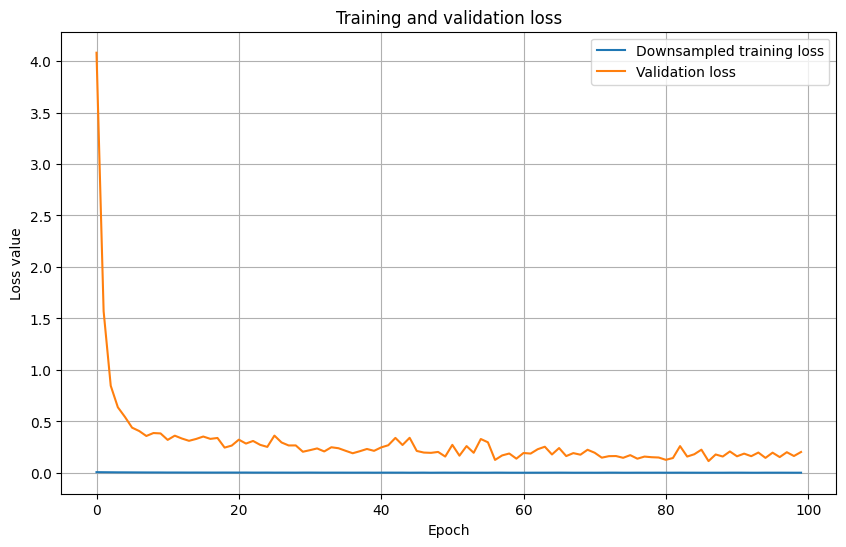

In [128]:
list1 = val_loss_history
list2 = train_loss_history

# downsampling the training loss becaus in each epoch there are 2 batches
downsampling_factor = len(train_loss_history) // len(val_loss_history)
train_loss_downsampled = signal.decimate(train_loss_history, downsampling_factor)

train_loss_downsampled = train_loss_downsampled[:len(val_loss_history)]
x = range(len(val_loss_history))

plt.figure(figsize=(10, 6))
plt.plot(x, train_loss_downsampled, label='Downsampled training loss')
plt.plot(x, val_loss_history, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.title('Training and validation loss')
plt.legend()
plt.grid(True)

plt.show()

IoU: tensor(0.9997)


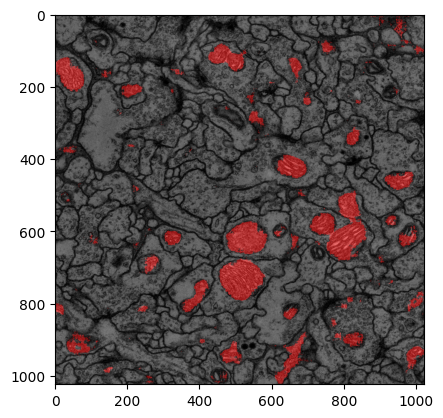

In [129]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

test_dataset = DrosophilaDataset(transform=False, training=2)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

for batch in test_loader:
    images, _ = batch
    images = images.to(device)
    outputs = model(images)

    images = images.cpu()
    outputs = outputs.cpu()

    # Compute IoU
    iou = intersection_over_union(images, outputs)
    print("IoU:", iou)
    # print(images.shape, outputs.shape)

    # Visualize the first image and its label for sanity check
    image = images.squeeze()
    mask = outputs.squeeze()
    # print(image.shape, mask.shape)
    mask[mask>0] = 1
    mask[mask<=0] = 0

    test_dataset.visualize(image, mask)
    break

## Implement here your training and test functions

## 4. Self-Supervised Learning

Here you will implement a function which extracts pseudo-cell segmentation maps to train your model on the pretext task. You will use the images of the training set to extract pseudo-labels and you should use the pseudo-labels as your target when calculating the loss. Modify your custom dataset class to extract pseudo-labels during pre-training.

To extract pseudo-labels, you can use OpenCV and follow these steps:
- Convert Image to GrayScale cv2.cvtColor().
- Apply histogram equalization i.e. cv2.equalizeHist().
- Apply binary inversion threshold i.e. cv2.THRESH_BIN_INV, use threshold range of [140, 170].
- Convert all values greater than 0 to 255 and 0 otherwise.

In [ ]:
def extract_pseudo_labels():
    pass

Afterwards, you will pre-train your model on the pseudo-label cell segmentation learning with same optimizer, batch, and loss function. However, pretrain only for 50 epochs. Then you will fine-tune the entire pretrained model (encoder and decoder) for 100 epochs assuming you have now access to the groundtruth of the data. You should notice an improvement in the test mIoU of about 10%.

In [ ]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

# First pretrain

# Fine tune entire model

# test model